# Demonstrations of Orbit_Cheby Functionality

 - This notebook contains a mixture of demos of finished code, as well as WIP experimentation with ways to speed-up the code 

In [1]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import os
import sys
from collections import Counter
import glob 
import warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------

# parent directory is */cheby_checker
HEAD_DIR = os.path.dirname(os.path.realpath(os.getcwd())) 
sys.path.append(os.path.join(HEAD_DIR))
print(f' HEAD_DIR: {HEAD_DIR} ')

# import nbody-related code from main cheby_checker directory
# - use this code to get the results of an nbody run ... 
# - see *Demonstate_Functionality_mpc_nbody.ipynb* for more details 
from cheby_checker import mpc_nbody, parse_input
importlib.reload(mpc_nbody)

# orbit_cheby & nbody_reader imports 
# - this is the actual code we are demonstrating
from cheby_checker import orbit_cheby
from cheby_checker import nbody_reader
importlib.reload(orbit_cheby)
importlib.reload(nbody_reader)


 HEAD_DIR: /Users/matthewjohnpayne/Envs/cheby_checker 


<module 'cheby_checker.nbody_reader' from '/Users/matthewjohnpayne/Envs/cheby_checker/cheby_checker/nbody_reader.py'>

In [2]:
# directory with sample data for development
DATA_DIR = os.path.join(HEAD_DIR, 'dev_data')
print(f' DATA_DIR: {DATA_DIR} ')

payne_file = os.path.join(DATA_DIR, '2022AA_demo.txt')
mike_file = os.path.join(DATA_DIR, 'simulation_states.dat')

 DATA_DIR: /Users/matthewjohnpayne/Envs/cheby_checker/dev_data 


#### Sample NBody Data
 - We need to have some data to apply orbit_cheby to ...
 - We can use the mpc_nbody module to supply these...
 - see *Demonstate_Functionality_mpc_nbody.ipynb* for more details 


In [3]:
# Sample NBody Data
# - We use the *mpc_nbody* routine to get the results of an nbody run ... 
# - see *Demonstate_Functionality_mpc_nbody.ipynb* for more details 
importlib.reload(mpc_nbody)

# Define some files that have data in them 
filenames = [os.path.join(DATA_DIR, file)
              for file in ['30101.eq0_horizons', '30102.eq0_horizons']]

# First, let's initiate the class with an input file:
Sim = mpc_nbody.NbodySim(filenames[0], 'eq')

# Now run the integrator, by calling the object. 
Sim(tstep=20, trange=1000)

#The results are all available inside the object now:
print(type(Sim))
for item in Sim.__dict__ : print(f'item:type = {item, type(Sim.__dict__[item])} ')



<class 'cheby_checker.mpc_nbody.NbodySim'>
item:type = ('pparticle', <class 'cheby_checker.parse_input.ParseElements'>) 
item:type = ('geocentric', <class 'bool'>) 
item:type = ('input_vectors', <class 'numpy.ndarray'>) 
item:type = ('input_n_particles', <class 'int'>) 
item:type = ('output_times', <class 'numpy.ndarray'>) 
item:type = ('output_vectors', <class 'numpy.ndarray'>) 
item:type = ('output_n_times', <class 'int'>) 
item:type = ('output_n_particles', <class 'int'>) 
item:type = ('time_parameters', <class 'list'>) 


##### plot the XYZ coords before doing anything with cheby's ...

Data shape: (544, 1, 6)
time shape: (544,)
Average timestep: 1.8510914333241872 days


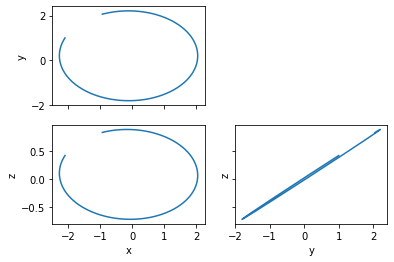

In [4]:
print(f"Data shape: {np.shape(Sim.output_vectors)}\n"
      f"time shape: {np.shape(Sim.output_times)}\n"
      f"Average timestep: {np.mean(Sim.output_times[1:]-Sim.output_times[:-1])} days")
states = Sim.output_vectors[:,0,:]
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0, 0].plot(states[:, 0], states[:, 1])
ax[0, 0].set_ylabel('y')
ax[1, 0].plot(states[:, 0], states[:, 2])
ax[1, 0].set_ylabel('z')
ax[1, 0].set_xlabel('x')
ax[1, 1].plot(states[:, 1], states[:, 2])
ax[1, 1].set_ylabel('z')
ax[1, 1].set_xlabel('y')
fig.delaxes(ax[0, 1])


# High - Level Functionality : *cheby_checker.orbit_cheby*
 - Illustration of high level usage. 
 - Detailed demonstrations provided lower-down ...

## (A) Use MSC_Loader to create MSC(s) from Sim ...

In [5]:
%%time
importlib.reload(mpc_nbody)
importlib.reload(orbit_cheby)

# Use the MSC_Loader to declare and populate a list of MSC objects direct from mpc_nbody.NbodySim object
MSCs = orbit_cheby.MSC_Loader(NbodySim = Sim).MSCs

INIT MSC_Loader...
Populating from NbodySim : ***NO*** designation information : Using ['0']
CPU times: user 22.1 ms, sys: 4.76 ms, total: 26.9 ms
Wall time: 28.8 ms


## (B) Use MSC_Loader to create MSC(s) from Numpy Arrays ...
 - N.B. This example is for a single-particle load. Both single- and multi-particle loads are demonstrated in more detail in the low-level functionality section below. 

In [6]:
%%time
importlib.reload(mpc_nbody)
importlib.reload(orbit_cheby)

# Here we use the arrays that are already in the Sim object
# But these could have come from anywhere: 
# - all that's important is that we have arrays of times & states ...
name = 'name_string'
times = Sim.output_times
states = Sim.output_vectors

# Use the MSC_Loader to declare and populate a list of MSC objects direct from mpc_nbody.NbodySim object
MSCs = orbit_cheby.MSC_Loader(primary_unpacked_provisional_designations = name, 
                              times_TDB = times,
                              statearray = states).MSCs

INIT MSC_Loader...
CPU times: user 15.8 ms, sys: 3.14 ms, total: 19 ms
Wall time: 17.1 ms


## (C) Use MSC_Loader to create MSC(s) from Database ...


##### (D) MSC_Loader can be used to create MSC(s) from text files : 
 - this is *not* expected to be important in regular usage, so we only describe this usage lower-down in the low-level functionality section ...  


<br>

<br>

<br>

<br>

<br>


# Low - Level Functionality : *cheby_checker.orbit_cheby*
 - Here I am assuming that the mpc_nbody module (see *Demonstate_Functionality_mpc_nbody.ipynb*) is available to supply data, and that we can now use the *orbit_cheby* routines to operate on that input nbody data, and use it to generate sets of chebyshev coefficients
 - The chebyshev coefficients are fit to "sectors" of data (e.g. 32-day chunks) and saved into suitable data structures 
 - I experiment with dictionaries, but find that numpy arrays are better/faster (surprise surprise)

#### (1) Declare an MSC (multi sector cheby) class object

In [7]:
importlib.reload(orbit_cheby)

# Declare an MSC (multi sector cheby) class object
M = orbit_cheby.MSC()

# Print out the object-type & its attributes 
print(type(M) )
print(dir(M))
del M 

<class 'cheby_checker.orbit_cheby.MSC'>
['HP_npix', 'HP_nside', 'HP_order', 'HPix', 'JDlist', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fetch_data_directory', 'covRaDec', 'covUV', 'covXYZ', 'dRaDecdXYZ', 'dUVdXYZ', 'dXYZdt', 'db_dir', 'db_filename', 'epsilon', 'evaluate_components', 'from_coord_arrays', 'from_sector_dict', 'generate_HP', 'generate_RaDec', 'generate_UnitVector', 'generate_XYZ', 'generate_cheb_for_sector', 'get_required_sector_dict', 'get_valid_range_of_dates', 'map_JD_to_sector_number', 'map_JD_to_sector_number_and_sector_start_JD', 'map_JDtimes_to_relative_times', 'map_sector_number_to_sector_start_JD', 'maxerr', 'maxorder', 'minorder', 'primary_unpacked_provisional_desi

#### (2)  Declare an MSC_Loader class object

In [8]:
importlib.reload(orbit_cheby)

# Declare an MSC_Loader class object
M = orbit_cheby.MSC_Loader()

# Print out the object-type & its attributes 
print(type(M) )
print(dir(M))
del M 

INIT MSC_Loader...

 ****** Defaulting to the production of a list of empty MSCs ****** 

	 This occurs (a) on erroneous input, and (b) when no input supplied

<class 'cheby_checker.orbit_cheby.MSC_Loader'>
['HP_npix', 'HP_nside', 'HP_order', 'HPix', 'JDlist', 'MSCs', 'NbodySim', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fetch_data_directory', '_generate_empty', '_populate_from_database', '_populate_from_nbody_array', '_populate_from_nbody_text', 'db_dir', 'db_filename', 'desig_dict', 'dict_of_dicts_coeffs', 'epsilon', 'filepath', 'get_required_sector_dict', 'map_JD_to_sector_number', 'map_JD_to_sector_number_and_sector_start_JD', 'map_JDtimes_to_relative_times', 'map_sector_number_to_se

#### (3)  Read data directly from array 
 - In practice, we will have the data in a numpy-array anyway, direct from the nbody sim (see high-level demo above)
 - Here we prepopulate some arrays with data
 - This is *not* doing anything associated with chebyshev polynomials at this point, simply reading data into arrays

#####  We need to get some data from file to play with ...

In [9]:
%%time 

# Pre-populate numpy array ...
name, times, states  = nbody_reader.parse_nbody_txt( mike_file )
print(type(name),name)
print(type(states), states.shape)
print(type(times), times.shape)

<class 'str'> nput vectors: [0.0 0.5 0.0 -0.024 0.0 0.0 ]
<class 'numpy.ndarray'> (1760, 6)
<class 'numpy.ndarray'> (1760,)
CPU times: user 25.1 ms, sys: 2.73 ms, total: 27.8 ms
Wall time: 25.8 ms


##### Plot the XYZ coords before doing anything with cheby's ...

Data shape: (1760, 6)
time shape: (1760,)
Average timestep: 0.3421301104222605 days


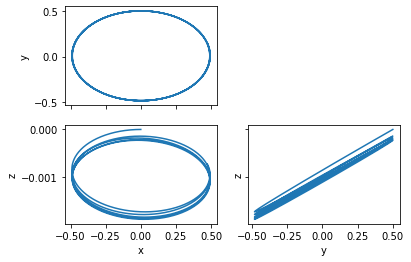

In [10]:
print(f"Data shape: {np.shape(states)}\n"
      f"time shape: {np.shape(times)}\n"
      f"Average timestep: {np.mean(times[1:]-times[:-1])} days")
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0, 0].plot(states[:, 0], states[:, 1])
ax[0, 0].set_ylabel('y')
ax[1, 0].plot(states[:, 0], states[:, 2])
ax[1, 0].set_ylabel('z')
ax[1, 0].set_xlabel('x')
ax[1, 1].plot(states[:, 1], states[:, 2])
ax[1, 1].set_ylabel('z')
ax[1, 1].set_xlabel('y')
fig.delaxes(ax[0, 1])
#ax[0, 0].set_aspect('equal')
#ax[1, 0].set_aspect('equal')
#ax[1, 1].set_aspect('equal')

#### (4) Use the data arrays to initialize an "MSC" (multi-sector-cheby) using the MSC_Loader class
 - Same as done in high-level demo above

In [11]:
%%time 
importlib.reload(orbit_cheby)

# Use MSC_Loader to initialize & return MSC
# N.B.(1) : Loads directly from array 
# N.B.(2) : Creates a list (of length 1 in this case of MSC objects
# N.B.(3) : Use ".MSCs" to access the list of .MSCs
# N.B.(4) : Plural !! : unpacked_provisional_designations 
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs
print( 'Returned variable is of type %r , and length %r  ' % (type(MSCs),len(MSCs) ) )
M = MSCs[0]
print( 'Entry in list is of type', type(M) )
print ( 'Number of sectors = ' , len(M.sector_coeffs) )

mn,mx = min(list(M.sector_coeffs.keys())),max(list(M.sector_coeffs.keys()))
print ( 'Min, Max Sector #s : ', mn, mx) 
print ( 'Shape of sector[mn] = ' , M.sector_coeffs[mn].shape )
print ( 'Shape of sector[mx] = ' , M.sector_coeffs[mx].shape )

print ( 'Range of validity : ', M.get_valid_range_of_dates() ) 
print ( 'primary_unpacked_provisional_designation : ', M.primary_unpacked_provisional_designation ) 



INIT MSC_Loader...
Returned variable is of type <class 'list'> , and length 1  
Entry in list is of type <class 'cheby_checker.orbit_cheby.MSC'>
Number of sectors =  18
Min, Max Sector #s :  504 521
Shape of sector[mn] =  (17, 6)
Shape of sector[mx] =  (17, 6)
Range of validity :  (2456128, 2456703.999999)
primary_unpacked_provisional_designation :  nput vectors: [0.0 0.5 0.0 -0.024 0.0 0.0 ]
CPU times: user 269 ms, sys: 5.32 ms, total: 274 ms
Wall time: 74.7 ms


#### (5) Evaluate XYZ positions of realistic data using the MSC's *generate_XYZ* method 
#### (5a) : 'mike_file'

INIT MSC_Loader...
eval_times:  2456128.0 2456703.0 576
initial times ... 2456117.5 2456719.3068642328
Final XYZs.shape =  (3, 576)
CPU times: user 312 ms, sys: 8.11 ms, total: 320 ms
Wall time: 101 ms


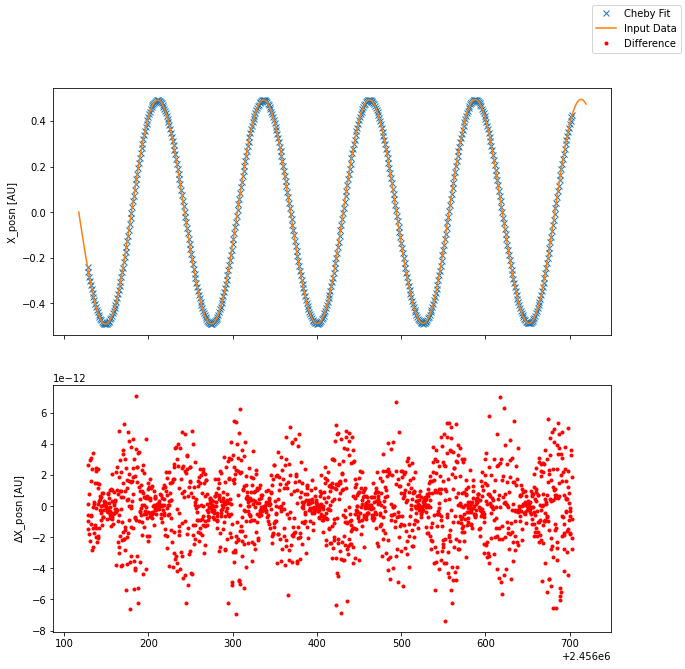

In [12]:
%%time 
importlib.reload(orbit_cheby)

# Reinitialize an MSC object, this time using the stright-from-textfile method
M = orbit_cheby.MSC_Loader(filepath = mike_file).MSCs[0]

# artificially creating an array of evaluation times that will be within the validrange
evaluation_times = np.arange(*M.get_valid_range_of_dates())
print('eval_times: ', evaluation_times[0], evaluation_times[-1], len(evaluation_times) )
print('initial times ...', times[0], times[-1])

# Call to get XYZ 
XYZs = M.generate_XYZ( evaluation_times )

# N.B. final shape = (3,len(times_TDB))
print('Final XYZs.shape = ', XYZs.shape)

# Make evaluation plots ... 
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex='col')
ax[0].set_ylabel('X_posn [AU]')
ax[1].set_ylabel('$\\Delta$X_posn [AU]')

# (1) Plot fitted "x" (== XYZs[0]) against time ... 
ax[0].plot( evaluation_times , XYZs[0] , 'x' , label = 'Cheby Fit ')

# (2) Plot the original "x" against time
ax[0].plot( times, states[:, 0] , '-', label='Input Data')

# (3) Plot the difference between the original and fit
ind = np.where( (times >= evaluation_times[0]) & (times <= evaluation_times[-1]) ) 
ax[1].plot( times[ind], M.generate_XYZ( times[ind] )[0] - states[:, 0][ind] , '.', label='Difference', c='r')

fig.legend() 

#### (5b) :  From Sim object ...



INIT MSC_Loader...
Populating from NbodySim : ***NO*** designation information : Using ['0']
initial times ... 2456117.641933589 2457122.784581884
eval_times:  2456128.0 2457119.0 992
Final XYZs.shape =  (3, 992)
 zero times ...  2456117.641933589 2456000.0


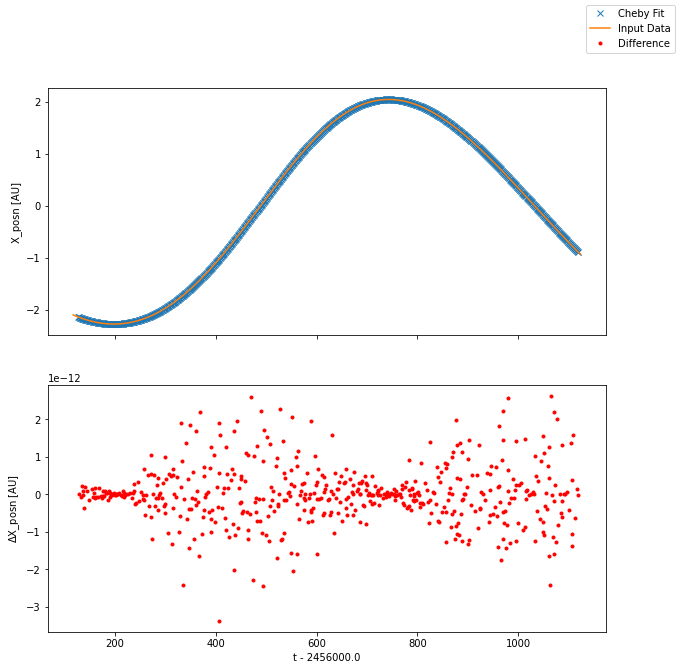

In [13]:
importlib.reload(orbit_cheby)
try: 
    del M
except: 
    pass 

# Reinitialize an MSC object, this time using the Sim-object approach
Sim = mpc_nbody.NbodySim(filenames[0], 'eq')
Sim(tstep=20, trange=1000)
M = orbit_cheby.MSC_Loader(NbodySim = Sim).MSCs[0]
times = Sim.output_times
states = Sim.output_vectors

# artificially creating an array of evaluation times that will be within the validrange
evaluation_times = np.arange(*M.get_valid_range_of_dates())
print('initial times ...', times[0], times[-1])
print('eval_times: ', evaluation_times[0], evaluation_times[-1], len(evaluation_times) )

# Call to get XYZ 
XYZs = M.generate_XYZ( evaluation_times )

# N.B. final shape = (3,len(times_TDB))
print('Final XYZs.shape = ', XYZs.shape)

# t0 
t0 = round(times[0],-3)
print(' zero times ... ' , times[0] , t0)

# Make evaluation plots ... 
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex='col')
ax[0].set_ylabel('X_posn [AU]')
ax[1].set_ylabel('$\\Delta$X_posn [AU]')

#ax[0].set_ylim([-2.5,2000])

# (1) Plot fitted "x" (== XYZs[0]) against time ... 
ax[0].plot( evaluation_times - t0 , XYZs[0] , 'x' , label = 'Cheby Fit ')

# (2) Plot the original "x" against time
ax[0].plot( times - t0, states[:, :, 0] , '-', label='Input Data')

# (3) Plot the difference between the original and fit
ind = np.where( (times >= evaluation_times[0]) & (times <= evaluation_times[-1]) ) 
ax[1].plot( times[ind]-t0, M.generate_XYZ( times[ind] )[0] - states[:,:, 0].flatten()[ind] , '.', label='Difference', c='r')
ax[1].set_xlabel(f't - {t0}')
fig.legend() 

#### (6) Evaluate components using the MSC's very low-level *evaluate_components* method 
 - This is not expected to be used as standard
 - But it underlies everything, so it's worth looking at ...
 - Here we demonstrate complete equivalence to the slightly higher level *generate_XYZ* method

In [19]:
print(f'times[ind].shape    = {times[ind].shape }')
print(f'states[ind].T.shape = {states[ind].T.shape }')

# Make the call to the low-level *evaluate_components*
evaluatedComponents      = M.evaluate_components( times[ind] )
evaluatedComponentsSlice = M.evaluate_components( times[ind] , component_slice_spec=slice(0,3))

# Make a call to the higher level *generate_XYZ*
XYZs = M.generate_XYZ( times[ind] )

# Show that the shape of the returned components is as expected ...
print( states[ind].T.shape , evaluatedComponents.shape ) 
assert evaluatedComponentsSlice.shape == XYZs.shape

# Look at the difference between 
# (a) the evaluatedComponents and the input states ... 
# (a) the evaluatedComponents and the generate_XYZ values ... 
plt.plot( times[ind], np.abs(evaluatedComponents[0] - states[:, 0][ind]) , '.',label='Eval - Inp',    c='b')
plt.plot( times[ind], np.abs(evaluatedComponents[0] - XYZs[0])           , '.',label='Eval - genXYX', c='r')
plt.legend()



times[ind].shape    = (538,)
states[ind].T.shape = (6, 1, 538)
(6, 1, 538) (6, 538)


ValueError: operands could not be broadcast together with shapes (538,) (538,6) 

#### (7) Directly from array for **MULTIPLE PARTICLES**
 - Want 3D array 
 - Will create this here by sticking together a few copies of the data for a single particle ...


In [231]:
%%time 
importlib.reload(orbit_cheby)

# Pre-populate numpy array ...
# - Note that (i) we need to allow for MULTIPLE NAMES
# - We are creating a 3D array of input coords
arrays, names = [],[] 
for i in range(1,5):
    name, times, states  = nbody_reader.parse_nbody_txt( mike_file )
    names.append(name+"_"+str(i))
    arrays.append(states)
states_3D = np.stack(arrays, axis=2)
states_3D.shape


CPU times: user 92 ms, sys: 11.9 ms, total: 104 ms
Wall time: 104 ms


(1760, 6, 4)

In [233]:
%%time 
importlib.reload(orbit_cheby)

# Use MSC_Loader to initialize & return MSC
# N.B.(1) : Loads directly from array 
# N.B.(2) : Creates a list (of length 4 in this case of MSC objects
# N.B.(3) : Use ".MSCs" to access the list of .MSCs
# N.B.(4) : Plural !! : unpacked_provisional_designations 
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = names, 
                            times_TDB = times, 
                            statearray = states_3D).MSCs
print( 'Returned variable is of type %r , and length %r  ' % (type(MSCs),len(MSCs) ) )
M = MSCs[0]
print( 'Entry [0] list is of type', type(M) )
print ( 'Number of sectors = ' , len(M.sector_coeffs) )

mn,mx = min(list(M.sector_coeffs.keys())),max(list(M.sector_coeffs.keys()))
print ( 'Min, Max Sector #s : ', mn, mx) 
print ( 'Shape of sector[mn] = ' , M.sector_coeffs[mn].shape )
print ( 'Shape of sector[mx] = ' , M.sector_coeffs[mx].shape )

print ( 'Range of validity : ', M.get_valid_range_of_dates() ) 
print ( 'primary_unpacked_provisional_designation : ', M.primary_unpacked_provisional_designation ) 



INIT MSC_Loader...
Returned variable is of type <class 'list'> , and length 4  
Entry [0] list is of type <class 'cheby_checker.orbit_cheby.MSC'>
Number of sectors =  20
Min, Max Sector #s :  503 522
Shape of sector[mn] =  (8, 6)
Shape of sector[mx] =  (8, 6)
Range of validity :  (2456096, 2456735.999999)
primary_unpacked_provisional_designation :  nput vectors: [0.0 0.5 0.0 -0.024 0.0 0.0 ]_1
CPU times: user 378 ms, sys: 11.1 ms, total: 389 ms
Wall time: 104 ms


#### (8) XYZ positions : Single Particle 
 - Here we are using a relatively low-level function (generate_XYZ) to find heliocentric XYZ positions using the stored data
 - It seems to be able to perform ~1e6 XYZ calculations per second (for a single object's chebyshev coeffs, where there are 27 sets of coefficients )
 - I assume that this will vary as the number of sectors changes 

INIT MSC_Loader...
Data shape: (1760, 6)
time shape: (1760,)
Average timestep: 0.3421301104222605 days


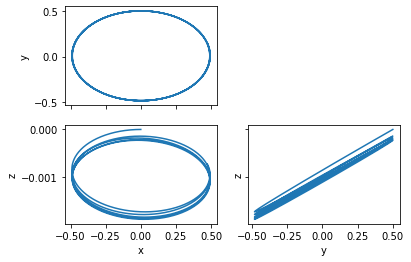

In [255]:
importlib.reload(orbit_cheby)

# Use the MSC_Loader to declare and populate a list of MSC objects direct from mpc_nbody.NbodySim object
M = orbit_cheby.MSC_Loader(filepath = mike_file).MSCs[0]

print(f"Data shape: {np.shape(states)}\n"
      f"time shape: {np.shape(times)}\n"
      f"Average timestep: {np.mean(times[1:]-times[:-1])} days")
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0, 0].plot(states[:, 0], states[:, 1])
ax[0, 0].set_ylabel('y')
ax[1, 0].plot(states[:, 0], states[:, 2])
ax[1, 0].set_ylabel('z')
ax[1, 0].set_xlabel('x')
ax[1, 1].plot(states[:, 1], states[:, 2])
ax[1, 1].set_ylabel('z')
ax[1, 1].set_xlabel('y')
fig.delaxes(ax[0, 1])
#ax[0, 0].set_aspect('equal')
#ax[1, 0].set_aspect('equal')
#ax[1, 1].set_aspect('equal')

(2456117.6430380116, 2457122.7836714266)

eval_times:  2456096.0 2456735.0 640
evaluation_times[0] = 2456096.0003472907 , evaluation_times[-1]=2456735.9989864333
Final XYZs.shape =  (3, 1000000)
CPU times: user 1.23 s, sys: 140 ms, total: 1.37 s
Wall time: 1.36 s


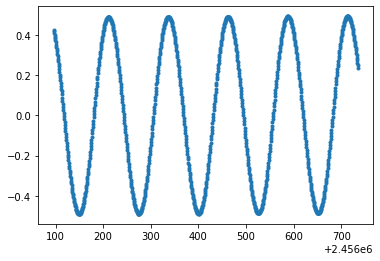

In [256]:
%%time 
importlib.reload(orbit_cheby)

nSample = int(1e6) 

evaluation_times = np.arange(*M.get_valid_range_of_dates())
print('eval_times: ', evaluation_times[0], evaluation_times[-1], len(evaluation_times) )

# Set up some evaluation times 
mn,mx = M.get_valid_range_of_dates()
evaluation_times = np.sort(mn + (mx-mn)*np.random.rand(nSample) )
print(f'evaluation_times[0] = {evaluation_times[0]} , evaluation_times[-1]={evaluation_times[-1]}')

# ******************   Low-level call to get XYZ ******************
XYZs = M.generate_XYZ( evaluation_times )

# N.B. final shape = (3,len(times_TDB))
print('Final XYZs.shape = ', XYZs.shape)

# Plot x == XYZs[0] against time ... 
every=1000
plt.plot( evaluation_times[::every] , XYZs[0][::every] , '.' ) 

# Observational UnitVector Calculations

###### SIFTER: This UV calc is used at the time of query to (a) get the approx HP (see below) and (b) to get refined positions for precise tracklet matching 
###### MPCHECKER: This UV calc is used at the time of query to get refined positions for any approx matches extracted from the precalculated data

 - These calculations require that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to generate a set of standardized input observatory-positions (using a silly ~circular approximation) and then provide those as inputs. 
     

In [122]:
%%time 
importlib.reload(orbit_cheby)

# Create a sample of observatory-positions as inputs 
# - Note that the NBody code uses BARYCENTRIC EQUATORIAL coords
# - So the Cheby's need to work-in/evaluate-to equatorial coords
# - Hence the observatory-positions will need to be in equatorial coords
nSample = int(1e6) 
evaluation_times = np.sort(2440000. + 999.*np.random.rand(nSample) )
r = 1.0 
XYZobservatory_equatorial = np.array( [r*np.cos(evaluation_times), 
                                        r*np.sin(evaluation_times) , 
                                        0.0001*r*np.cos(evaluation_times)])
XYZobservatory_equatorial.shape 

CPU times: user 322 ms, sys: 21.3 ms, total: 344 ms
Wall time: 343 ms


(3, 1000000)

In [123]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...


 - In this initial experiment *BELOW* I find that it takes: 
        ~1s to evaluate 1e6 unit vectors for a single object using an APPROX (non-iterated) approach
        ~3s to evaluate 1e6 unit vectors for a single object using a NON-APPROX (iterated) approach 
 

In [124]:
%%time 

# Now evaluate some unit vectors [[APPROXIMATE calculation]]
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
UVs = M.generate_UnitVector(  evaluation_times , 
                            XYZobservatory_equatorial, 
                            APPROX = True)

# N.B. final shape = (3,len(times_TDB))
UVs.shape 

CPU times: user 871 ms, sys: 277 ms, total: 1.15 s
Wall time: 1.15 s


(3, 1000000)

In [125]:
%%time 

# Now evaluate some unit vectors [[EXACT Calculation]]
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
UVs = M.generate_UnitVector( evaluation_times , 
                                    XYZobservatory_equatorial, 
                                    APPROX = False
                                              )
# N.B. final shape = (3,len(times_TDB))
print(UVs.shape)


(3, 1000000)
CPU times: user 2.63 s, sys: 798 ms, total: 3.42 s
Wall time: 3.44 s


### Observational HP Calculations
###### SIFTER: This HP routine will be used intensively at the time a search is executed to find the APPROX HP location of an object over a series of many nights 
###### MPCHECKER: This HP routine will be used in the precalculation phase to find-and-store the HP location of an object across a series of nights 


 - Because this is a wrapper around the unitvector call, the hp call again requires that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to use the obs-posns generated above
 
This brief experiment finds that the time to calcuate 1e6 healpix is essentially the same as the time to  generate the underlying 1e6 unitvectors

In [126]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...


In [127]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate the HP vectors  
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
HPs= M.generate_HP( evaluation_times , 
                XYZobservatory_equatorial, 
                APPROX = True )
# N.B. final shape = (3,len(times_TDB))
HPs.shape , evaluation_times.shape


CPU times: user 1.34 s, sys: 328 ms, total: 1.67 s
Wall time: 1.67 s


((1000000,), (1000000,))

# RA, Dec

In [128]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...


In [129]:
# Make some obs positions 
nSample = int(1e6) 
evaluation_times = np.sort(2440000. + 999.*np.random.rand(nSample) )
r = 1.0 
XYZobservatory_equatorial = np.array( [r*np.cos(evaluation_times), 
                                        r*np.sin(evaluation_times) , 
                                        0.0001*r*np.cos(evaluation_times)])


In [130]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate the HP vectors  
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
RaDec = M.generate_RaDec( evaluation_times , 
                observatoryXYZ=XYZobservatory_equatorial, 
                APPROX = True )
print(RaDec.shape)


(2, 1000000)
CPU times: user 900 ms, sys: 271 ms, total: 1.17 s
Wall time: 1.17 s


# Uncertanties and Covariances 

 ## (1) We might need the gradient of  XYZ as a function of time 

In [131]:
%%time 
importlib.reload(orbit_cheby)

# Create a sample of observatory-positions as inputs 
# - Note that the NBody code uses BARYCENTRIC EQUATORIAL coords
# - So the Cheby's need to work-in/evaluate-to equatorial coords
# - Hence the observatory-positions will need to be in equatorial coords
nSample = int(1e0) 
evaluation_times = np.sort(2440000. + 999.*np.random.rand(nSample) )
r = 1.0 
XYZobservatory_equatorial = np.array( [r*np.cos(evaluation_times), 
                                        r*np.sin(evaluation_times) , 
                                        0.0001*r*np.cos(evaluation_times)])


# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...
CPU times: user 417 ms, sys: 7.48 ms, total: 424 ms
Wall time: 423 ms


In [132]:
%%time 
# ******************   Low-level call to get XYZ ******************
XYZs = M.generate_XYZ( evaluation_times )

# N.B. final shape = (3,len(times_TDB))
#print('Final XYZs.shape = ', XYZs.shape)
if np.all(np.array(XYZs.shape) < 20) : 
    print(XYZs)
    

[[-1.8143096 ]
 [-2.03114144]
 [ 0.        ]]
CPU times: user 458 µs, sys: 149 µs, total: 607 µs
Wall time: 813 µs


In [133]:
%%time 
# Evaluate the **** GRADIENT ****
M.dXYZdt(evaluation_times)

CPU times: user 310 µs, sys: 30 µs, total: 340 µs
Wall time: 317 µs


array([[ 0.00777411],
       [-0.0069442 ],
       [ 0.        ]])

## (2) Think about the variation in other parameters as XYZ are varied

In [134]:
import numdifftools as nd
importlib.reload(orbit_cheby)


<module 'orbit_cheby.orbit_cheby' from '/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/orbit_cheby/orbit_cheby.py'>

In [135]:
importlib.reload(orbit_cheby)
# Create a sample of observatory-positions as inputs 
# - Note that the NBody code uses BARYCENTRIC EQUATORIAL coords
# - So the Cheby's need to work-in/evaluate-to equatorial coords
# - Hence the observatory-positions will need to be in equatorial coords
nSample = int(1e1) 
evaluation_times = np.sort(2440000. + 999.*np.random.rand(nSample) )
r = 1.0 
XYZobservatory_equatorial = np.array( [r*np.cos(evaluation_times), 
                                        r*np.sin(evaluation_times) , 
                                        0.0001*r*np.cos(evaluation_times)])


# Generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            primary_unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

UVs = M.generate_UnitVector(  evaluation_times , 
                            XYZobservatory_equatorial, 
                            APPROX = True)

# N.B. final shape = (3,len(times_TDB))
UVs 

INIT MSC_Loader...


array([[-5.47275445e-01, -9.96542252e-01, -9.68329181e-01,
        -9.50243876e-01, -8.39715678e-01, -6.84809471e-01,
         1.52561949e-01,  3.36972422e-01,  6.46213290e-01,
         9.99255034e-01],
       [ 8.36952558e-01, -8.30875484e-02, -2.49676986e-01,
        -3.11506938e-01, -5.43026316e-01, -7.28722161e-01,
        -9.88293909e-01, -9.41514517e-01, -7.63156853e-01,
        -3.85924447e-02],
       [ 4.93835667e-05, -4.77983850e-06, -5.24127369e-06,
         5.58411056e-05,  1.14005314e-05, -2.54151197e-05,
         3.60705942e-05, -4.16156982e-05, -3.42123372e-05,
         2.60499218e-05]])

### Variation in UV as a func of variation in XYZ

$ \frac{d(UVx,UVy,UVz)({(X,Y,Z)},t)}{d{(X,Y,Z)}} $

***THE FOLLOWING IS CLEARER WHEN LOOKING AT THE RADEC ONE BELOW ***
N.B. each element is 3x3
So visually we have 

dUVx/dX , dUVy/dX, , dUVz/dX

dUVx/dY , dUVy/dY, , dUVz/dY

dUVx/dZ , dUVy/dZ, , dUVz/dZ


In [136]:
%%time

result = M.dUVdXYZ(evaluation_times, XYZobservatory_equatorial)
print(result.shape) 
 


(10, 3, 3)
CPU times: user 9.48 ms, sys: 3.01 ms, total: 12.5 ms
Wall time: 9.67 ms


### Variation in RA,Dec as a func of variation in XYZ

$ \frac{d(RA,DEC)({(X,Y,Z)},t)}{d{(X,Y,Z)}} $

N.B. each element is 3x2
So visually we have 

dRA/dX , dDEC/dX

dRA/dY , dDEC/dY

dRA/dZ , dDEC/dZ


In [90]:
%%time

dRD = M.dRaDecdXYZ(evaluation_times, XYZobservatory_equatorial)
print(dRD.shape) 
 


(10, 3, 2)
CPU times: user 12 ms, sys: 2.04 ms, total: 14 ms
Wall time: 12.3 ms


### CoV Matrix for XYZ
 - Get this direct from the coefficient evaluation

In [91]:
cov_XYZ = M.covXYZ(evaluation_times)
cov_XYZ.shape, cov_XYZ

((10, 3, 3),
 array([[[ 0.00000000e+00, -2.67253843e-09, -5.34507687e-09],
         [-2.67253843e-09, -1.60352306e-08, -1.87077690e-08],
         [-5.34507687e-09, -1.87077690e-08, -2.93979228e-08]],
 
        [[ 0.00000000e+00, -2.54790794e-09, -5.09581587e-09],
         [-2.54790794e-09, -1.52874476e-08, -1.78353556e-08],
         [-5.09581587e-09, -1.78353556e-08, -2.80269873e-08]],
 
        [[ 0.00000000e+00, -2.10064542e-09, -4.20129083e-09],
         [-2.10064542e-09, -1.26038725e-08, -1.47045179e-08],
         [-4.20129083e-09, -1.47045179e-08, -2.31070996e-08]],
 
        [[ 0.00000000e+00, -1.52113367e-09, -3.04226734e-09],
         [-1.52113367e-09, -9.12680202e-09, -1.06479357e-08],
         [-3.04226734e-09, -1.06479357e-08, -1.67324704e-08]],
 
        [[ 0.00000000e+00,  1.37316995e-09,  2.74633990e-09],
         [ 1.37316995e-09,  8.23901970e-09,  9.61218965e-09],
         [ 2.74633990e-09,  9.61218965e-09,  1.51048694e-08]],
 
        [[ 0.00000000e+00,  2.31558894e-09

### CoV Matrix for RA,Dec
- https://iopscience.iop.org/article/10.1086/316868/pdf

$\Sigma_{\bf\theta} = \left[\frac{d\theta({\bf\alpha},t)}{d{\bf\alpha}}\right]^T  \Sigma_{\bf\alpha}  \left[\frac{d\theta({\bf\alpha},t)}{d{\bf\alpha}}\right]$ 

$\Sigma_{(R,D)} = \left[\frac{d(R,D)({(X,Y,Z)},t)}{d{(X,Y,Z)}}\right]^T  \Sigma_{(X,Y,Z)}  \left[\frac{d(R,D)({(X,Y,Z)},t)}{d{(X,Y,Z)}}\right]$ 


In [92]:
# Explicitly evaluate the first & last components we expect ...
np.linalg.multi_dot([dRD[0].T , cov_XYZ[0], dRD[0]]) ,  np.linalg.multi_dot([dRD[-1].T , cov_XYZ[-1], dRD[-1]])

(array([[-3.89651289e-06,  2.29448957e-06],
        [ 2.29448957e-06, -1.74031132e-06]]),
 array([[1.53067798e-05, 8.94465387e-06],
        [8.94465387e-06, 7.08768126e-06]]))

In [93]:
%%time 
# Evaluate using the standard functionality
cov_RD = M.covRaDec(evaluation_times, XYZobservatory_equatorial)
cov_RD[0], cov_RD[-1] , cov_RD.shape

CPU times: user 13.1 ms, sys: 2.23 ms, total: 15.3 ms
Wall time: 13.3 ms


(array([[-3.89651289e-06,  2.29448957e-06],
        [ 2.29448957e-06, -1.74031132e-06]]),
 array([[1.53067798e-05, 8.94465387e-06],
        [8.94465387e-06, 7.08768126e-06]]),
 (10, 2, 2))